# Base

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt 
import numpy as np
import random
import json
import seaborn as sns
from tqdm import tqdm

In [ ]:
DIR_DATA="/content/drive/MyDrive/BasicMobileLab/content/data/Dataset/" 
DIR_NET_SAVING="/content/drive/MyDrive/BasicMobileLab/content/data/net/"
DIR_RESULTS="/content/drive/MyDrive/BasicMobileLab/content/data/"

In [ ]:
manualSeed=1
torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
g = torch.Generator()
g.manual_seed(manualSeed)

# Functions

In [ ]:
def suppr(dic):
  """ 
    결측치 제거
  """
  bornemax=np.quantile(dic["features"],0.99,axis=0) # 데이터 분할
  bornemin=np.quantile(dic["features"],0.01,axis=0) # 데이터 분할
  indicesmauvais=np.where(np.sum(np.add(bornemin>np.array(dic["features"]),np.array(dic["features"])>bornemax),axis=1)>0)[0]
  k=0

  for i in indicesmauvais:
    del dic["features"][i-k]
    del dic["label"][i-k]
    k+=1

  return dic

def extract_ds_from_dict(data):
  """ 
    각 state에서 irrelavant extract를 삭제하고 딕셔너리로 반환
  """
  Letat=[]

  for i in range(0,4):
    dictio={}
    features=[data["features"][j] for j in np.where(np.array(data["label"])==i+1)[0]] 
    label=[data["label"][j] for j in np.where(np.array(data["label"])==i+1)[0]]
    dictio["features"]=features
    dictio["label"]=label
    Letat.append(dictio.copy())

  neutral=Letat[0] # neutral = 0
  stress=Letat[1] # stress = 1
  amuse=Letat[2] # amusement = 2
  medi=Letat[3] # meditation = 3
  neutral=suppr(neutral)
  stress=suppr(stress)
  amuse=suppr(amuse)
  medi=suppr(medi)
  features=[]
  label=[]
  dict_id={}

  for m in range(0,4):
    dictio=Letat[m]
    features+=[x for x in dictio["features"]] 
    label+=[x for x in dictio["label"]]

  dict_id["features"]=features
  dict_id["label"]=label
  return dict_id.copy()

def conf_mat(net,datal,trsh):
  """ 
    dataloader에 따라 2개의 confusion matrix와 상태 예측을 위한 threshold  계산(임계치 이상의 subject는 스트레스 상태로 판단)
  2x2 confusion matrix : Stress and No stress as label for line and column
  3x4 confusion matrix : {Total ; Stress ; No stress} as label for the lines
                         {neutralal ; Stress ; Amusement; Meditation} as label for the columns
  """
  x=datal[0].float().to(device)
  y=net(x).view(-1)
  pred=(y>trsh).int()
  label=datal[1].float().to(device).view(-1).int()
  num=datal[2].float().to(device).int()
  comp=torch.eq(label,pred).int()
  mat_label=np.zeros((2,4))
  mat_nolbl=np.zeros((2,2))

  for i in range(0,4):
    tens=torch.where(num==i+1,1,0)
    numtot=torch.sum(tens).item()
    num_G=torch.sum(torch.where(torch.mul(tens,comp)==1,1,0)).item()

    if i ==1:
      mat_nolbl[0,0]+=num_G
      mat_nolbl[1,0]+=numtot-num_G
      mat_label[0,i]=num_G
      mat_label[1,i]=numtot-num_G

    else:
      mat_nolbl[1,1]+=num_G
      mat_nolbl[0,1]+=numtot-num_G
      mat_label[1,i]=num_G
      mat_label[0,i]=numtot-num_G


  return mat_label,mat_nolbl

def fusion_dic(list_dic):
  """
    리스트로부터 딕셔너리(dataset) 병합 (각 딕셔너리는 subject의 데이터셋을 나타냄)
  """
  features=[]
  label=[]
  dic_f={}

  for dic in list_dic:
    features+=dic["features"]
    label+=dic["label"]

  dic_f["features"]=features
  dic_f["label"]=label
  return dic_f

def proportion(dic, indice, prop):
  """ 
    균형 잡힌 training을 위해 균형 잡힌 dataset 반환(reduced by the factor prop)
  """
  tot=len(indice)
  features=[dic["features"][j] for j in indice[::int(np.ceil(tot/prop))]]
  label=[dic["label"][j] for j in indice[::int(np.ceil(tot/prop))]]
  return features,label

def eq_dic(dic):
  """ 
    dictionnary of a subject에서 균형 잡힌 dataset 반환(same ammount of data for neutralal/stress/amusement/relax condition)
  """
  indice_neutral=np.where(np.array(dic["label"])==1)[0]
  indice_stress=np.where(np.array(dic["label"])==2)[0]
  indice_amu=np.where(np.array(dic["label"])==3)[0]
  indice_med=np.where(np.array(dic["label"])==4)[0]
  nbr_neutral=len(indice_neutral)
  nbr_stress=len(indice_stress)
  nbr_amu=len(indice_amu)
  nbr_med=len(indice_med)
  prop=min([3*nbr_neutral,nbr_stress,3*nbr_amu,3*nbr_med])
  prop_stress=prop
  prop_neutral=int(0.333*prop)
  prop_amu=int(0.333*prop)
  prop_med=int(0.333*prop)
  features=[]
  label=[]
  dic_f={}
  tempf,templ=proportion(dic,indice_neutral,prop_neutral)
  features+=tempf
  label+=templ
  tempf,templ=proportion(dic,indice_stress,prop_stress)
  features+=tempf
  label+=templ
  tempf,templ=proportion(dic,indice_amu,prop_amu)
  features+=tempf
  label+=templ
  tempf,templ=proportion(dic,indice_med,prop_med)
  features+=tempf
  label+=templ
  dic_f["features"]=features
  dic_f["label"]=label
  
  return dic_f

# DS creation kfold

In [ ]:
class ds_wesad(Dataset):
    """
    0 neutral
    1 stress
    2 amusement
    3 relax
    """
    def __init__(self, dic):
        self.samples = []
        self.dic=dic
        for i in range(0,len(dic["label"])):
            num=dic["label"][i]
            stress=num==2
            x=np.array(dic["features"][i])
            self.samples.append((x,int(stress),num))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

In [ ]:
"""
cross validation 프로세스를 처리하고 교차 검증을 위한 여러 training / validation data dictionary 생성
"""

name_list= ['WESADECG_S2.json', 'WESADECG_S3.json', 'WESADECG_S4.json', 'WESADECG_S5.json', 'WESADECG_S6.json', 'WESADECG_S7.json',
 'WESADECG_S8.json', 'WESADECG_S9.json', 'WESADECG_S10.json', 'WESADECG_S11.json', 'WESADECG_S13.json', 'WESADECG_S14.json',
 'WESADECG_S15.json', 'WESADECG_S16.json']

#assert (len(name_list)==14)  ONE Subject for testing S17
list_dic_ds=[]
cntr=0

for k in range(0,14):   # 0~14
  for j in range(k,14):

    if k!=j :  
      f1 = open(DIR_DATA+name_list[k])
      f2 = open(DIR_DATA+name_list[j])
      data_1 = json.load(f1)
      data_2 = json.load(f2)
      dic_3=fusion_dic([data_1,data_2])   # 2명의 데이터로 데이터셋 생성
      dic_v=extract_ds_from_dict(dic_3)   # 2명의 데이터로부터 validation dictionnary 생성
      L=[]

      for i in range(0,len(name_list)):   # subject 개수만큼 반복
        if (i!=k and i!=j):
          f=open(DIR_DATA+name_list[i])   # k, j도 아닌 subject
          data = json.load(f)
          dic=eq_dic(data)
          L.append(dic) # L에 붙임

      assert (len(L)==12)
      dic_4=fusion_dic(L) 
      dic_t=extract_ds_from_dict(dic_4)
      list_dic_ds.append([dic_t,dic_v,k,j]) 
      # 12명의 데이터로부터 training dictionnary 생성. 모든 데이터는 balanced 되었고 결측치 제거됨.
      cntr+=1
      if cntr%10==0:
        print(cntr)

10
20
30
40
50
60
70
80
90


In [ ]:
""" 
  각 데이터 dictionary에 대해 multiple dataset 생성(첫 번째는 training dataset, 두 번째는 validation dataset)
"""
list_ds=[]
cntr=0
for sample in list_dic_ds:
  list_ds.append([ds_wesad(sample[0]),ds_wesad(sample[1]),sample[2],sample[3]]) #[training dataset; validation dataset(from subjects k and j); k; j]
  cntr+=1

# Model

In [ ]:
from torch.nn.modules.activation import LeakyReLU
""" DNN Model """

def init_weight(m):
    """Initialization of the weights"""
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_() 

class ClassifierECG(nn.Module):
    def __init__(self, ngpu):
        super(ClassifierECG, self).__init__()
        self.ngpu = ngpu
        self.nnECG = nn.Sequential(
            nn.Linear(12,128,bias=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(128,64,bias=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(64,16,bias=True),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(16,4,bias=True),
            nn.BatchNorm1d(4),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(4,1,bias=True),
            nn.Sigmoid()
        )
        self.nnECG.apply(init_weight)

    def forward(self, input):
        return self.nnECG(input)

# Training

In [ ]:
def training(net,dataloader_t,dataloader_v,num_epochs,j,k):
  """ 
    Dataset에서 BCELoss를 사용하여 train한 후 
    각 epoch에 대해 net weights가 저장되고, mean error가 계산되어 훈련 및 Valdiation 데이터 세트에 대한 손실을 플롯한다.
  """ 
  Loss = []
  Lossv= []
  for epoch in range(num_epochs):
      L_t=[]
      L_v=[]
      for i, dataj in enumerate(dataloader_t, 0):
          net.zero_grad()
          x=dataj[0].float().to(device)
          yhat=dataj[1].float().to(device)
          yhat=yhat.view(-1,1)
          y=net(x)
          err_t=nn.BCELoss()(y.float(),yhat.float())
          err_t.backward()
          optimizer.step()
          L_t.append(err_t.item())
      for i, dataj in enumerate(dataloader_v, 0):
        net.eval()     
        x=dataj[0].float().to(device)
        yhat=dataj[1].float().to(device)
        yhat=yhat.view(-1,1)
        y=net(x)
        err_v=nn.BCELoss()(y.float(),yhat.float())
        L_v.append(err_v.item())
      err=np.mean(L_t)
      errv=np.mean(L_v)
      Loss.append(err)
      Lossv.append(errv)
      torch.save(net.state_dict(), DIR_NET_SAVING+"net_"+str(j)+"_"+str(k)+"_epoch_"+str(epoch)+".pth")
  return [Lossv,np.argmin(Lossv)]

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

num_workers = 2
batch_size = 32
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")  

L=[]    
cntr=0

for ds in tqdm(list_ds):
  net= ClassifierECG(ngpu).to(device)
  lr=0.0001
  beta1=0.9
  optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
  dataset_t=ds[0]
  dataset_v=ds[1]
  k=ds[2]
  j=ds[3]
  dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  L.append(training(net,dataloader_t,dataloader_v,15,j,k))

100%|██████████| 91/91 [1:35:00<00:00, 62.64s/it]


In [ ]:
import dill

In [ ]:
with open('/content/drive/MyDrive/BasicMobileLab/content/data/model/ECG_stressdetector_model.pkl','wb') as fw:
    dill.dump(ClassifierECG, fw)

# Save Results

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [ ]:
with open(DIR_RESULTS+"results.json","w") as file:
    json.dump(L,file,cls=NpEncoder)

# Load Results

In [ ]:
with open(DIR_RESULTS+"results.json","r") as file:
    L=json.load(file)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
num_workers = 2
batch_size = 32
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")  

In [ ]:
"""
혼동행렬 계산
This cell compute the confusion matrixes (one with no label and one with label) with the best model of each fold (91 folds)
=> (prediction of the network as line label and true emotional state as column label)
The ploted matrixes are the mean+/-std of all the confusion matrixes (all folds)

This cell also compute the accuracy, precision, recall and F1 score of each fold model and stores these metrics in a list
"""

confusionlabelmean=np.zeros((2,4))
confusionmean=np.zeros((2,2))
acc_list=[]
prec_list=[]
recall_list=[]
f1_list=[]
confusion_label_list=[]
confusion_list=[]

for n in range(0,len(L)):
  if n%10==0:
    print(n)
  k=list_ds[n][2]
  j=list_ds[n][3]
  dataset_t=list_ds[n][0]
  dataset_v=list_ds[n][1]
  epch=np.argmin(L[n][0])
  net= ClassifierECG(ngpu).to(device)
  lr=0.0001
  beta1=0.9
  optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
  net.load_state_dict(torch.load(DIR_NET_SAVING+"net_"+str(j)+"_"+str(k)+"_epoch_"+str(epch)+".pth"))
  dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  trsh=0.5
  net.eval()
  confusionlabel=np.zeros((2,4))
  confusion=np.zeros((2,2))
  length_dsv=0
  for i, datal in enumerate(dataloader_v, 0):
        confusionlabelt,confusiont=conf_mat(net,datal,trsh)
        confusion+=confusiont
        confusionlabel+=confusionlabelt 
        length_dsv+=batch_size

  TP=confusion[0,0]
  TN=confusion[1,1]
  FN=confusion[1,0]
  FP=confusion[0,1]
  acc=(TP+TN)/(TP+FP+FN+TN)
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  F1score=(2*recall*precision)/(recall+precision)
  acc_list.append(acc)
  prec_list.append(precision)
  recall_list.append(recall)
  f1_list.append(F1score)
  confusion_label_list.append(100*confusionlabel/length_dsv)
  confusion_list.append(100*confusion/length_dsv)


confusionmean=np.round(np.mean(confusion_list,axis=0),3)
confusionlabelmean=np.round(np.mean(confusion_label_list,axis=0),3)
confusionstd=np.round(np.std(confusion_list,axis=0),3)
confusionlabelstd=np.round(np.std(confusion_label_list,axis=0),3)
annot_confusion=np.array([str(a)+"+/-"+str(b) for a,b in zip(confusionmean.reshape(-1).tolist(),confusionstd.reshape(-1).tolist())]).reshape(confusionmean.shape)
annot_confusion_label=np.array([str(a)+"+/-"+str(b) for a,b in zip(confusionlabelmean.reshape(-1).tolist(),confusionlabelstd.reshape(-1).tolist())]).reshape(confusionlabelmean.shape)
x_axis_confl = ['neutral','stress','amusement','meditation'] # labels for x-axis
y_axis_confl = ['stress','no stress'] # labels for y-axis
x_axis_conf = ['stress','no stress']
y_axis_conf = ['stress','no stress']
sns.set(rc={"figure.figsize":(15, 5)})
fig, axs = plt.subplots(ncols=2,figsize=(33,9))
sns.heatmap(confusionmean.astype('int32'), xticklabels=x_axis_conf, yticklabels=y_axis_conf,annot=annot_confusion,ax=axs[0],fmt = '')
axs[0].set_xlabel('Ground Truth')
axs[0].set_ylabel('Prediction')
axs[0].title.set_text('Confusion matrix label : Stress/No Stress (population in %)')
sns.heatmap(confusionlabelmean.astype('int32'), xticklabels=x_axis_confl, yticklabels=y_axis_confl, annot=annot_confusion_label,ax=axs[1],fmt = '')
axs[1].set_xlabel('Ground Truth')
axs[1].set_ylabel('Prediction')
axs[1].title.set_text('Confusion matrix label : emotionnal state (population in %)')

NameError: ignored

# Metrics :

The 4 following figures are the distribution of accuracy, precision, recall and f1 score of all best models (for each fold)

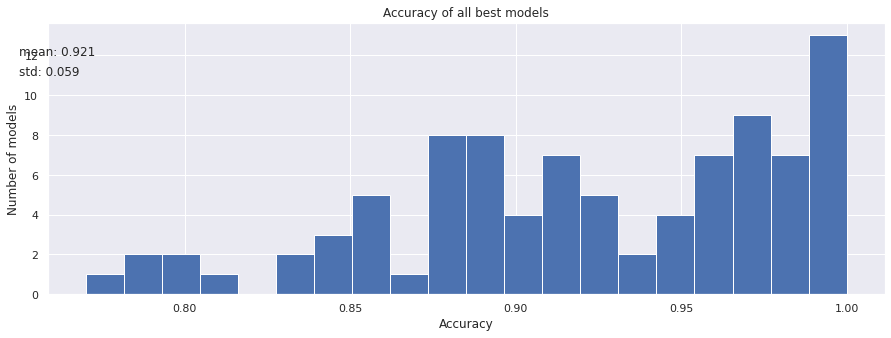

In [ ]:
mes=acc_list
plt.hist(mes,bins=20)
plt.title('Accuracy of all best models')
plt.xlabel('Accuracy') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.75, 12, txtm)
plt.text(0.75, 11, txtstd)
plt.show()

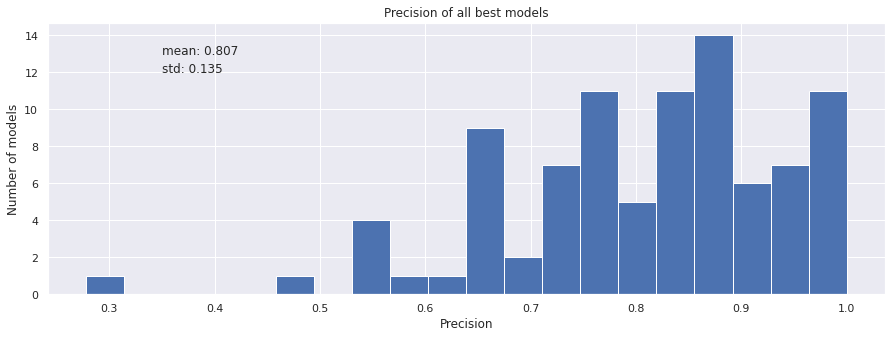

In [ ]:
mes=prec_list
plt.hist(mes,bins=20)
plt.title('Precision of all best models')
plt.xlabel('Precision') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.35, 13, txtm)
plt.text(0.35, 12, txtstd)
plt.show()

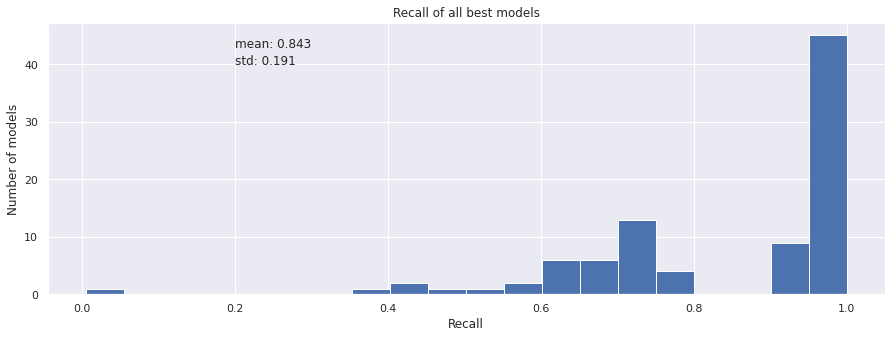

In [ ]:
mes=recall_list
plt.hist(mes,bins=20)
plt.title('Recall of all best models')
plt.xlabel('Recall') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.2, 43, txtm)
plt.text(0.2, 40, txtstd)
plt.show()

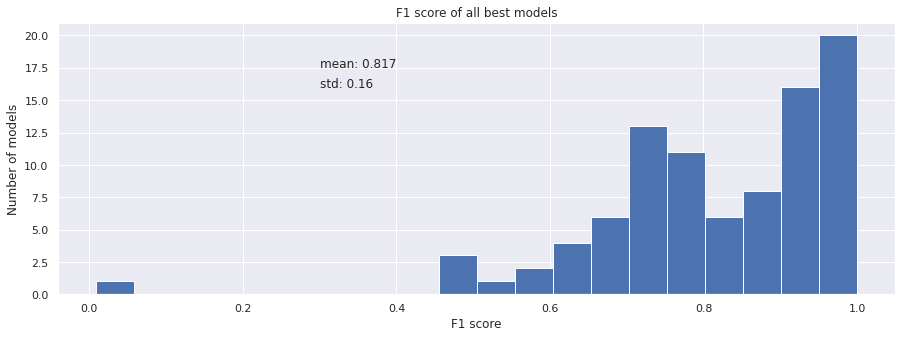

In [ ]:
mes=f1_list
plt.hist(mes,bins=20)
plt.title('F1 score of all best models')
plt.xlabel('F1 score') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.3, 17.5, txtm)
plt.text(0.3, 16, txtstd)
plt.show()